In [1]:
from itertools import product
import numpy as np
import pandas as pd
from ADRprofilePrediction import Pairs2Mat, evaluation, evaluation2
from APPFC import completion
from Models import loadHyperpar
import seaborn as sns 
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as path_effects
import json
import pingouin as pg
from functools import reduce

In [115]:

SEs = {}
SIDER = Pairs2Mat(path="data/drug_se.tsv",colname1="1_x",colname2="5")
column_sums = np.sum(SIDER, axis=0)
SEs["SIDER"] = SIDER.loc[:, (column_sums >= 0)]
OFFSIDES = Pairs2Mat(path="data/OFFSIDES.csv",colname1="drug_concept_name",colname2="condition_concept_name",sep = ",")
column_sums = np.sum(OFFSIDES, axis=0)
SEs["OFFSIDES"] = OFFSIDES.loc[:, column_sums >= 0]

In [116]:
features_dict = {
    "target":Pairs2Mat(path="data/drug_target.tsv",colname1="0",colname2="1"),
    "enzyme":Pairs2Mat(path="data/drug_enzyme.tsv",colname1="0",colname2="1"),
    "Chem":pd.read_csv("data/drug_chemsfp.tsv",sep = "\t",header=0,index_col=0),
    "DGI":Pairs2Mat(path="data/interactions.tsv",colname1="drug_claim_name",colname2="gene_name"),
    "transporter":Pairs2Mat(path="data/drug_transporter.tsv",colname1="0",colname2="1"),
    "pathway":Pairs2Mat(path="data/drug_pathway.tsv",colname1="0",colname2="1"),
    "indication":Pairs2Mat(path="data/drug_indication.tsv",colname1="1_x",colname2="6")
}

In [117]:
features_dict["target"].shape

(2926, 2283)

In [118]:
SEs["OFFSIDES"].shape

(2730, 14540)

In [124]:
intersect_idx = np.intersect1d(features_dict["DGI"].index, SEs["OFFSIDES"].index)

In [125]:
len(intersect_idx)

1680

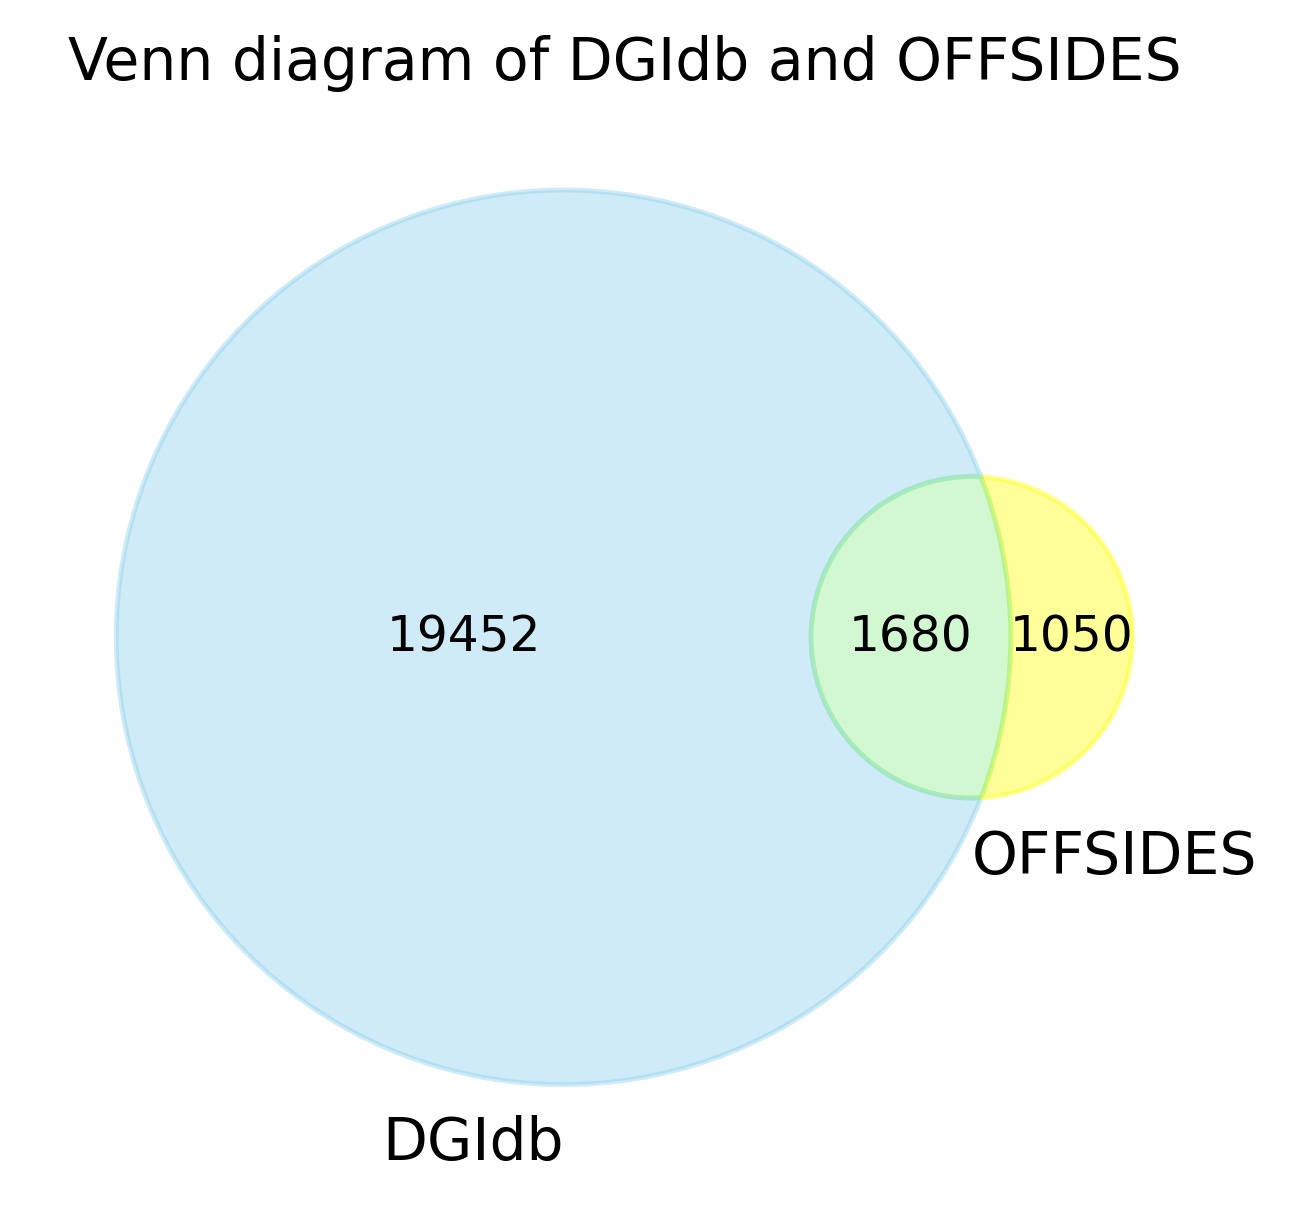

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import numpy as np

# Define dataset sizes
total_feature_drugs = 21132
total_adr_drugs = 2730
intersection_drugs = 1680

# Step 1: Venn Diagram for the two datasets
plt.figure(figsize=(8, 4), dpi=350)
venn = venn2(subsets=(total_feature_drugs - intersection_drugs, 
               total_adr_drugs - intersection_drugs, 
               intersection_drugs), 
      set_labels=('DGIdb', 'OFFSIDES'))
venn.get_patch_by_id('10').set_color('skyblue')  # Color for Set 1 only
venn.get_patch_by_id('01').set_color('yellow')  # Color for Set 2 only
venn.get_patch_by_id('11').set_color('Lightgreen')  # Color for intersection
plt.title("Venn diagram of DGIdb and OFFSIDES")
plt.savefig(fname=f"figs/venn.jpg", bbox_inches="tight")
plt.show()


T-statistic: 9.54283778587748
P-value: 2.232814545654476e-21


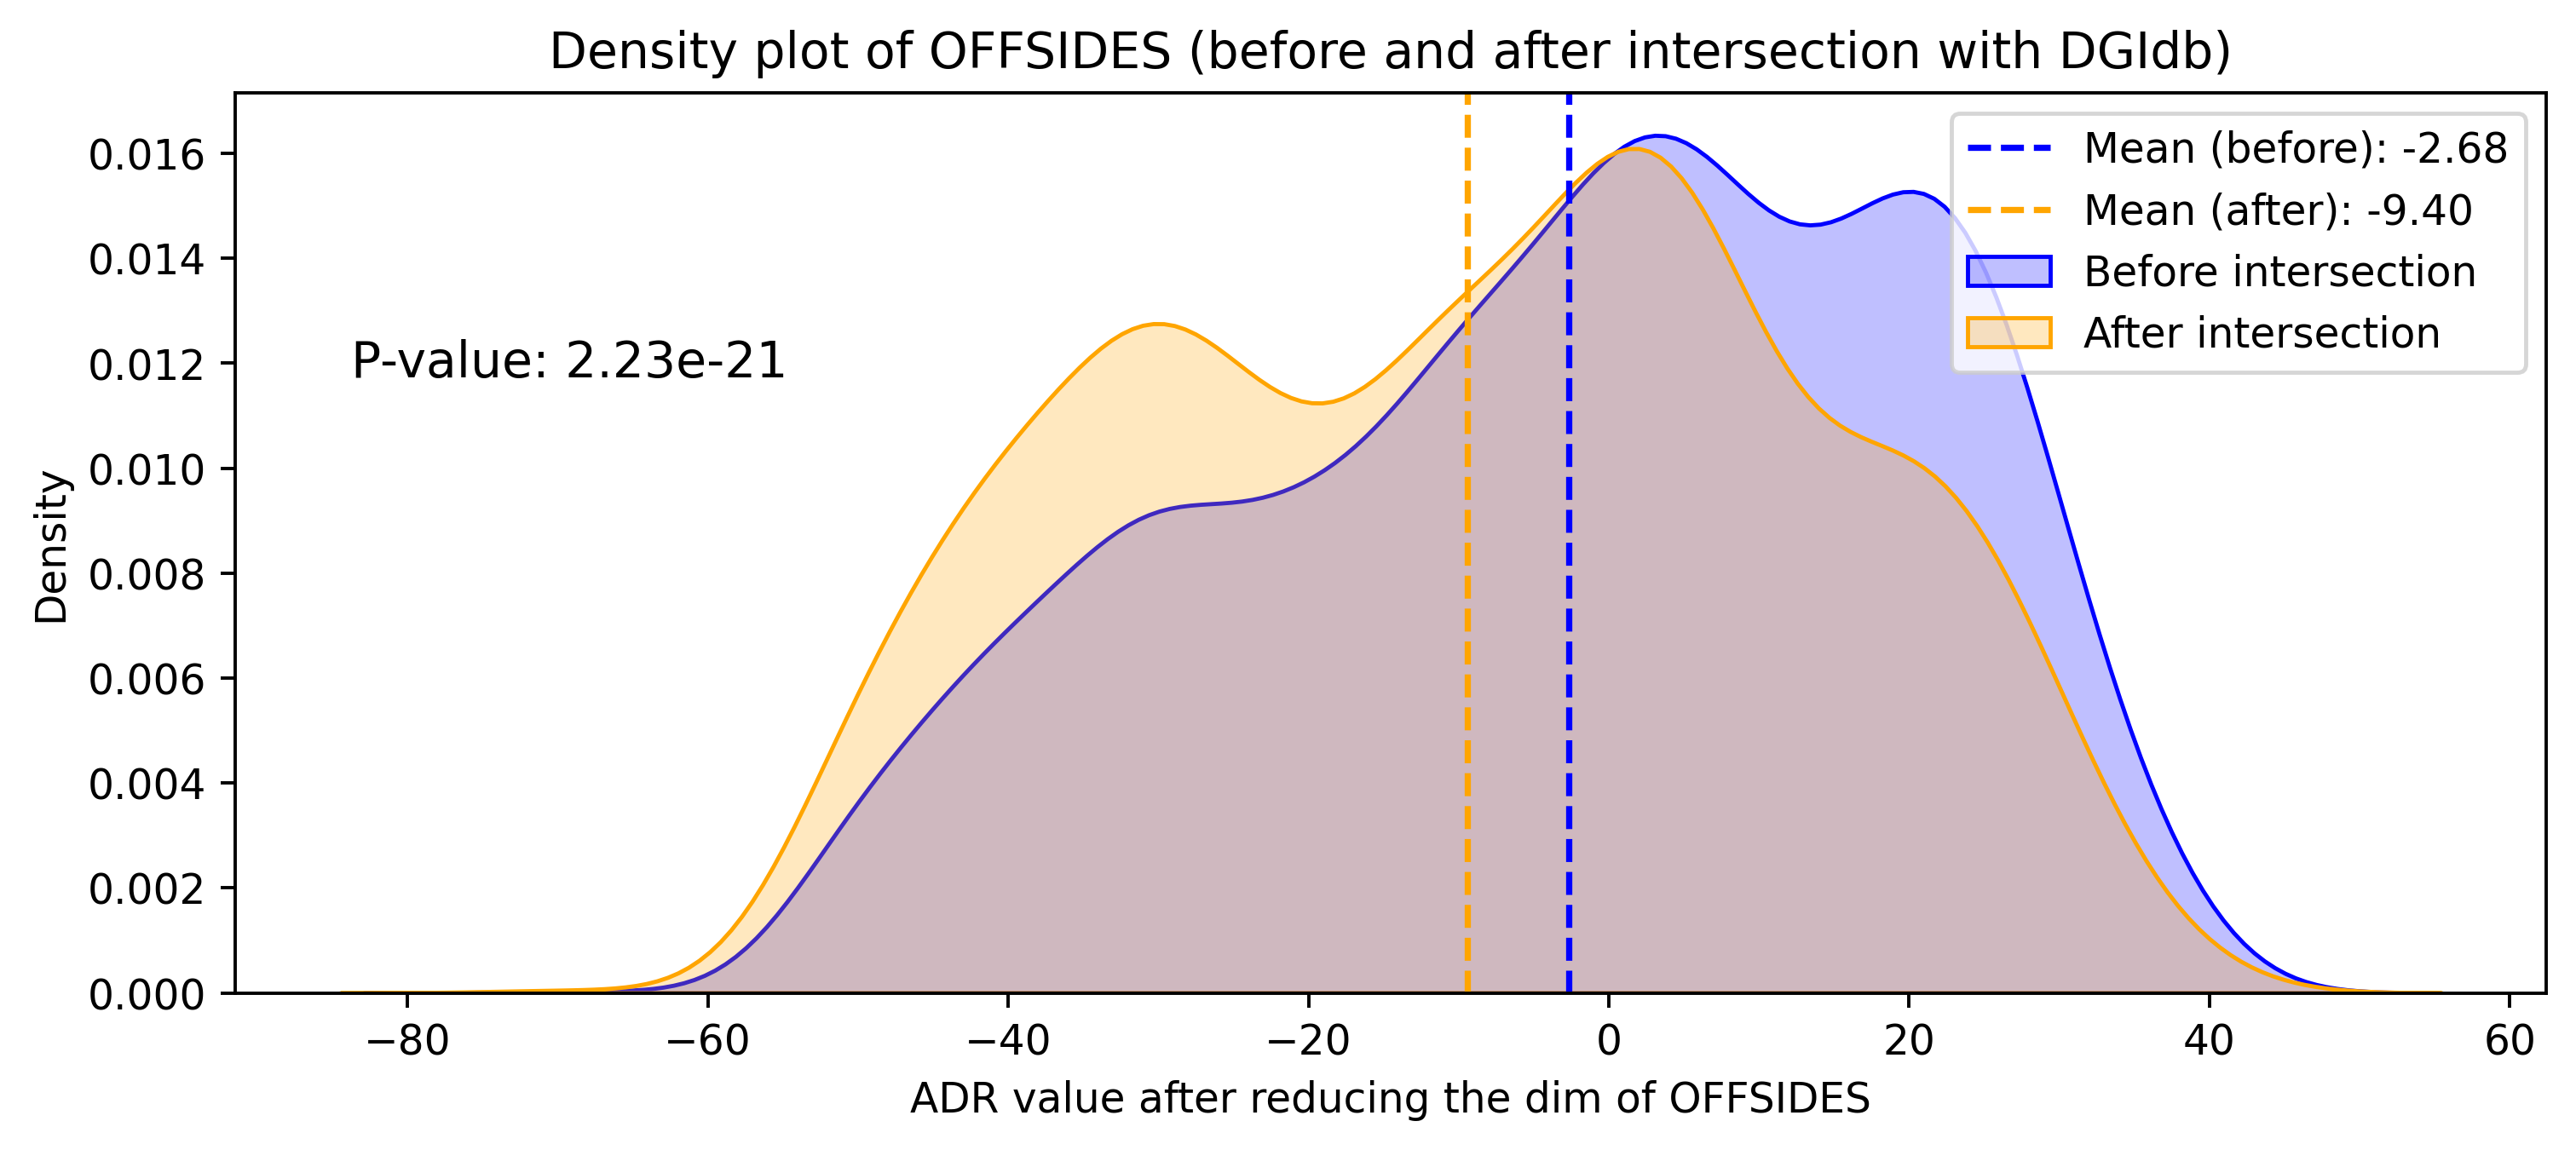

In [161]:

adr_data = SEs["OFFSIDES"]
# pca = PCA(n_components=3)
# adr_pca = pca.fit_transform(adr_data)

tsne = TSNE(n_components=2, random_state=1949)
adr_pca = tsne.fit_transform(adr_data)

adr_index = adr_data.index.tolist()
adr_pca_df = pd.DataFrame(adr_pca, index=adr_index)

# Simulating intersection by randomly choosing 1020 drugs from the ADR data
adr_pca_intersection = np.array(adr_pca_df.loc[intersect_idx])

# Step 3: Density Plot for ADR data before and after intersection
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 4), dpi=350)
# Density plot for all drugs in ADR data
sns.kdeplot(adr_pca[:,0], shade=True, color='blue', label="Before intersection")
# Density plot for intersected drugs in ADR data
sns.kdeplot(adr_pca_intersection[:,0], shade=True, color='orange', label="After intersection")
mean_before = np.mean(adr_pca[:,0])
mean_after = np.mean(adr_pca_intersection[:,0])

# Add vertical lines at the means
plt.axvline(mean_before, color='blue', linestyle='--', label=f'Mean (before): {mean_before:.2f}')
plt.axvline(mean_after, color='orange', linestyle='--', label=f'Mean (after): {mean_after:.2f}')

# Example data before and after intersection
before_intersection = np.random.normal(0, 1, 100)  # Data before
after_intersection = np.random.normal(1, 1, 100)   # Data after

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(adr_pca[:,0], adr_pca_intersection[:,0])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
plt.text(0.05, 0.7, f'P-value: {p_value:.2e}', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, color='black')

plt.xlabel("ADR value after reducing the dim of OFFSIDES")
plt.ylabel("Density")
plt.title("Density plot of OFFSIDES (before and after intersection with DGIdb)")
plt.legend()
plt.savefig(fname=f"figs/density.jpg", bbox_inches="tight")
plt.show()

/home/yezhao/anaconda3/envs/tf-2/lib/python3.9/site-packages/matplotlib_venn/layout/venn2/exact.py:83: UserWarning: Both circles have zero area
  warnings.warn("Both circles have zero area")


TypeError: _compute_colors() takes 2 positional arguments but 3 were given

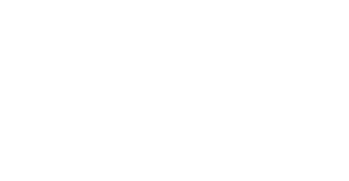

In [145]:
# import matplotlib.pyplot as plt
# from matplotlib_venn import venn

# Define sets
set1 = {1, 2, 3, 4}
set2 = {3, 4, 5, 6}
set3 = {4, 5, 6, 7}

# Create a Venn diagram for three sets
venn2({ 'Set1': set1, 'Set2': set2, 'Set3': set3 }, 
     set_colors=('skyblue', 'lightgreen', 'orange'))

# Show the plot
plt.title("Venn Diagram with Custom Colors")
plt.show()
